100%|██████████| 161M/161M [00:05<00:00, 33.3MB/s]

Extracting files...


[INFO] Dataset path: /root/.cache/kagglehub/datasets/fedesoriano/cifar100/versions/1
[INFO] Data Loaded. Train shape: (50000, 32, 32, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.0869 - loss: 4.4554 - val_accuracy: 0.2267 - val_loss: 3.3604
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.2528 - loss: 3.0619 - val_accuracy: 0.2593 - val_loss: 3.1773
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.3462 - loss: 2.5632 - val_accuracy: 0.4024 - val_loss: 2.3231
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4023 - loss: 2.2910 - val_accuracy: 0.4772 - val_loss: 1.9619
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.4370 - loss: 2.1003 - val_accuracy: 0.4705 - val_loss: 2.0195
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4731 - loss: 1.9601 - val_accuracy: 0.5019 - val_loss: 1.8259
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4988 - loss: 1.8244 - val_accuracy: 0.5341 - val_loss: 1.7113
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5197 -

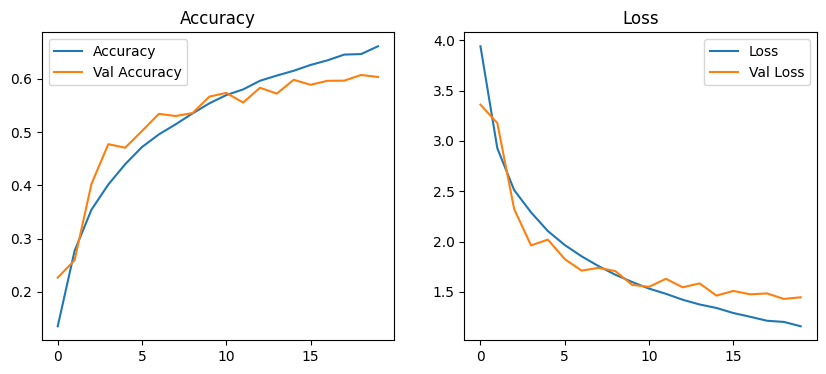

313/313 - 1s - 4ms/step - accuracy: 0.6033 - loss: 1.4463

Final Test Accuracy (CIFAR-100): 60.33%


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import kagglehub

# --- 1. LOAD DATA DARI KAGGLEHUB ---
# Download dataset (Outputnya adalah path folder cache lokal)
path = kagglehub.dataset_download("fedesoriano/cifar100")
print(f"[INFO] Dataset path: {path}")

# Fungsi helper untuk unpickle file binary CIFAR
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Fungsi untuk load dan reshape data agar bisa dibaca CNN (Format: N, 32, 32, 3)
def load_data_from_folder(datadir):
    # Nama file standar CIFAR-100 python version
    train_file = os.path.join(datadir, 'train')
    test_file = os.path.join(datadir, 'test')
    meta_file = os.path.join(datadir, 'meta')

    train_dict = unpickle(train_file)
    test_dict = unpickle(test_file)
    meta_dict = unpickle(meta_file)

    # Ambil data label (fine_labels untuk 100 kelas spesifik)
    y_train = np.array(train_dict[b'fine_labels'])
    y_test = np.array(test_dict[b'fine_labels'])

    # Ambil data gambar dan reshape
    # Aslinya flat vector (N, 3072) -> Reshape ke (N, 3, 32, 32) -> Transpose ke (N, 32, 32, 3)
    x_train = np.array(train_dict[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    x_test = np.array(test_dict[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    # Load nama kelas
    label_names = [x.decode('utf-8') for x in meta_dict[b'fine_label_names']]

    return (x_train, y_train), (x_test, y_test), label_names

# Eksekusi loading
try:
    (train_images, train_labels), (test_images, test_labels), class_names = load_data_from_folder(path)
    print(f"[INFO] Data Loaded. Train shape: {train_images.shape}")
except FileNotFoundError:
    print("[ERROR] Struktur file di path kagglehub berbeda. Pastikan isinya file 'train' dan 'test'.")
    # Fallback ke Keras datasets jika gagal parsing manual
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

# Normalisasi
train_images, test_images = train_images / 255.0, test_images / 255.0

# --- 2. MODEL ARCHITECTURE (Diperkuat untuk 100 Kelas) ---
model = models.Sequential([
    # Block 1
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Block 2
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Block 3
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Classifier
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(100)
])

# --- 3. COMPILING ---
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# --- 4. TRAINING ---
history = model.fit(train_images, train_labels, epochs=20,
                    validation_data=(test_images, test_labels))

# --- 5. VISUALISASI ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Print Final Accuracy
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f"\nFinal Test Accuracy (CIFAR-100): {test_acc*100:.2f}%")